# Predicting Game-Related Newsletter Subscription from Player Characteristics in Minecraft

## Introduction
### Background
Minecraft is a popular open-world sandbox video game that is widely loved by its diverse age group fan base. The characteristics of this game being played by a large variety of people makes it a great game to use as a research platform. At the University of British Columbia, a research group in Computer Science led by Frank Wood used a Minecraft server to study player behaviors. Particularily, they aim to analyze in-game behaviors and player characteristics to better recruit participants and allocate server resources for ongoing studies. One of their three questions of interests is to understand what kind of players are more likely to engage with the study long-term, a proxy for which is whether they subscribe to a game-related newsletter.

### Research Question
Can a player's age and played hours predict their likelihood of subscribing to a game-related newsletter in the Minecraft study dataset?

### Data Description
The dataset used is `players.csv`, containing 196 observations with the following variables: 
|Variable                       | Type      | Description |
|--------------------------------|------------|--------|
|`hashedEmail`|`character`|`Unique email (hashed) for each player`|
|`name`|`character`|`First name of the player`|
|`Age`|`numeric`|`Age of the players`|
|`gender`|`factor`|`Player's self-identified gender`|
|`experience` |`factor`|`Self-reported experience level in Minecraft`|
|`played_hours`|`numeric`|`Number of hours the player has spent in-game`|
|`subscribe`|`logical`|`Whether the player subscribed to the newsletter`|

### Observations and Issues:
- 2 NA values found in the `age` column.
- `played_hours` had a right-shewed distribution with outliers up to 227 hours, while the median is at 0.1 hours.
- Variables `hashedEmail` and `name` were dropped for being identifiers.
- To address the scaling issues, `played_hours` was log-transformed using `log1p()`.
- Age and log_hours were standardized (centered and scaled).

In [1]:
install.packages("stargazer")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
library(stargazer)
library(cowplot)
set.seed(742003)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
players <- read_csv("data/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
head(players,6)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


## Methods & Results
### Data Preparation
- Data was cleaned to best fit the data anlysis. Variables that were not useful (i.e. not "characteristics" of players) were removed (`hashedEmail` and `name`).
- All necessary non-numeric variables were turned into factors.
- Age was renamed to age for clean name
- Any missing values were removed.

In [5]:
cleaned_players <- players |>
    select(-hashedEmail, -name) |>
    mutate(subscribe = as.factor(subscribe),
          experience = as.factor(experience),
          gender = as.factor(gender)) |>
    drop_na() |>
    rename(age = Age)
head(cleaned_players,6)

experience,subscribe,played_hours,gender,age
<fct>,<fct>,<dbl>,<fct>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
Amateur,TRUE,0.7,Female,21
Regular,TRUE,0.1,Male,21
Amateur,TRUE,0.0,Female,17


- Summary statistics for `cleaned_players` numeric variables. (Used stargazer from ECON 325 for visually pleasing summary statistics table)

In [6]:
stargazer(
    as.data.frame(cleaned_players[c("played_hours", "age")]),
    type = "text",
    title = "Summary Statistics for Played Hours and Age",
    digits = 6,
    summary.stat = c("mean", "median", "sd", "min", "max", "n"))


Summary Statistics for Played Hours and Age
Statistic      Mean     Median  St. Dev.    Min       Max      N 
-----------------------------------------------------------------
played_hours 5.904639  0.100000 28.497930 0.000000 223.100000 194
age          20.520620    19    6.174667     8         50     194
-----------------------------------------------------------------


- Mean and stardard deviation is not scaled and centered.

We begin by examining the distribution of key categorical variables: `subscribe`, `experience`, and `gender`. These will give us insight into the palyer base sample and may hint at relationships with our outcome variable.

In [7]:
sub_count <- cleaned_players |>
    count(subscribe) |>
    arrange(desc(n))
experience_count <- cleaned_players |>
    count(experience) |>
    arrange(desc(n))
gender_count <- cleaned_players |>
    count(gender) |>
    arrange(desc(n))
sub_count
experience_count # use experience and gender for difference player types
gender_count

subscribe,n
<fct>,<int>
TRUE,142
FALSE,52


experience,n
<fct>,<int>
Amateur,63
Veteran,48
Beginner,35
Regular,35
Pro,13


gender,n
<fct>,<int>
Male,124
Female,37
Non-binary,15
Prefer not to say,11
Two-Spirited,5
Agender,2


The code above counts the number of players by their subscription status, experience level, and gender. This helps us understand how many players fall into each category and gives us a starting point for comparing different types of players. 
We visualize these distributions using bar plots:

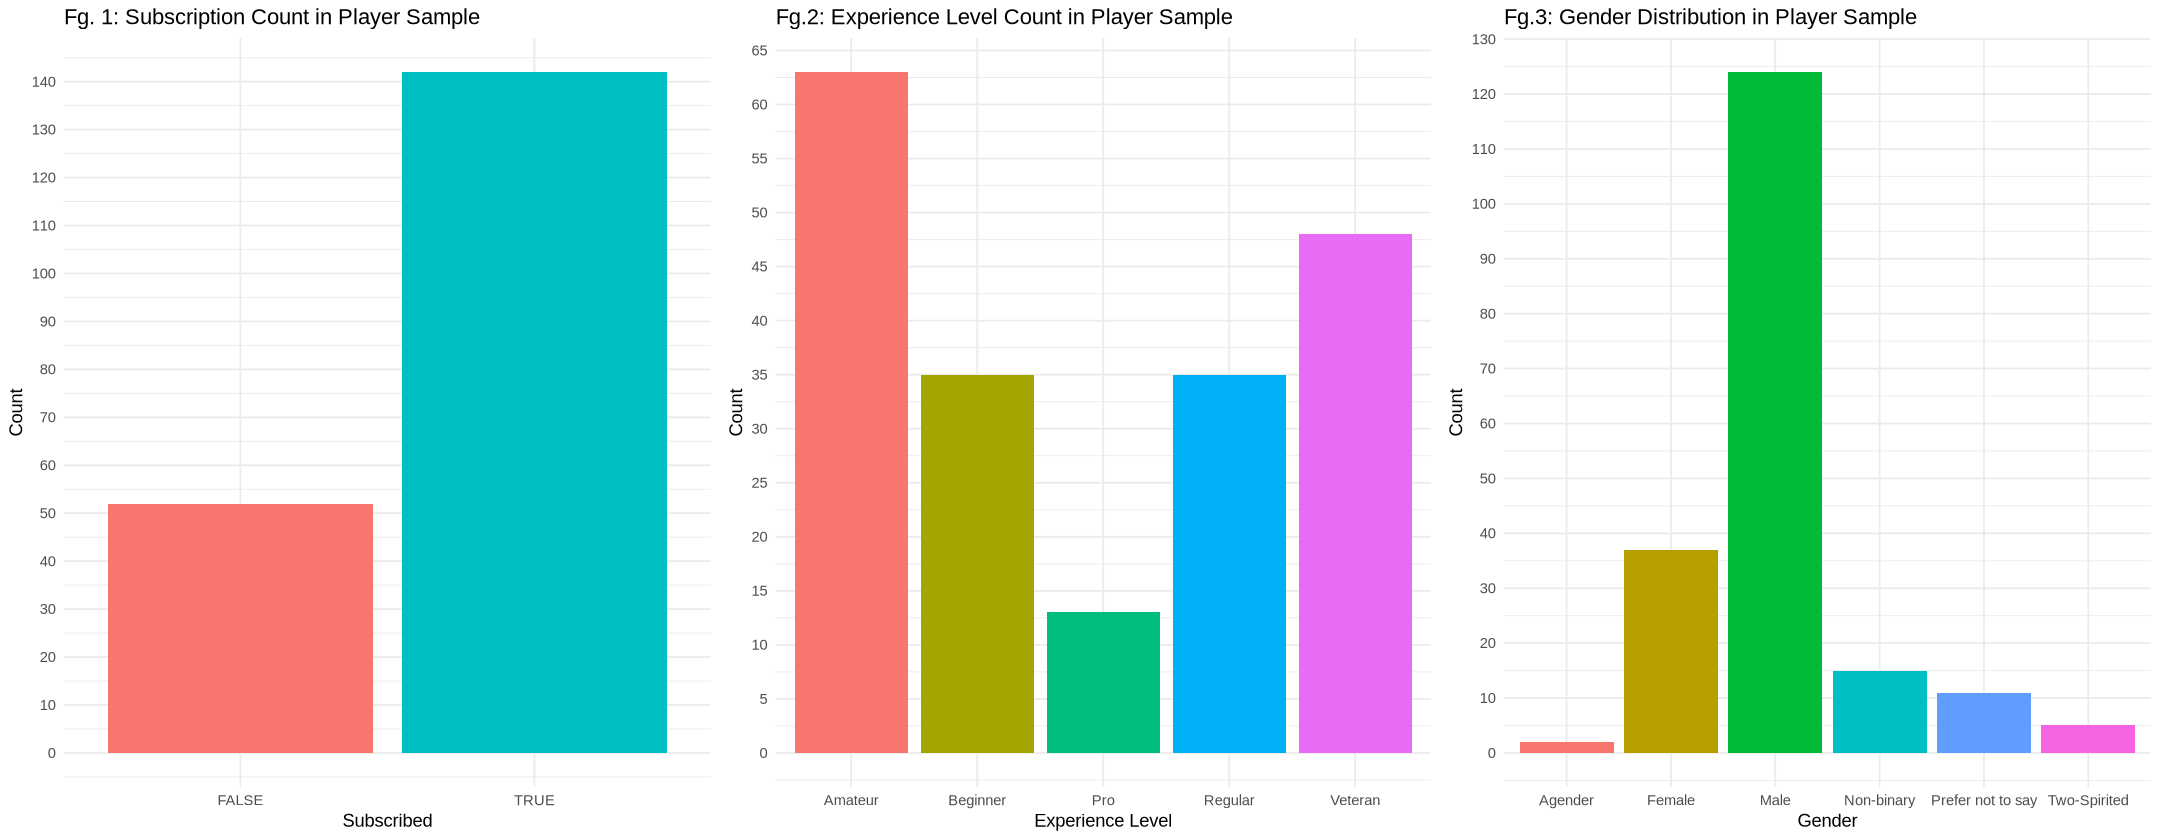

In [8]:
options(repr.plot.width = 18, repr.plot.height = 7)
sub_plot <- sub_count |>
    ggplot(aes(x = subscribe, y = n, fill = subscribe)) +
    geom_col(show.legend = FALSE) +
    labs(title = "Fg. 1: Subscription Count in Player Sample", x = "Subscribed", y = "Count") +
    scale_y_continuous(breaks = seq(0, max(sub_count$n)+10, by = 10))+
    theme_minimal()
exp_plot <- experience_count |>
    ggplot(aes(x = experience, y = n, fill = experience)) +
    geom_col(show.legend = FALSE) +
    labs(title = "Fg.2: Experience Level Count in Player Sample", x = "Experience Level", y = "Count") +
    scale_y_continuous(breaks = seq(0, max(experience_count$n)+5, by = 5))+
    theme_minimal()
gender_plot <- gender_count |>
    ggplot(aes(x = gender, y = n, fill = gender)) +
    geom_col(show.legend = FALSE) +
    labs(title = "Fg.3: Gender Distribution in Player Sample", x = "Gender", y= "Count") +
    scale_y_continuous(breaks = seq(0, max(gender_count$n)+10, by = 10))+
    theme_minimal()
factor_level_graph <- plot_grid(sub_plot, exp_plot, gender_plot, nrow = 1)
factor_level_graph

These figures (Fg. 1-3) illustrate the frequency of each category in `subscribe`, `experience`, and `gender`, respectively. By plotting them, we can quickly assess dominant categories, such as overwhelming amount of males and large number of subscription from participants, which is important for understanding model biases. 
\
To better understand how gameplay hours vary across different experience levels, we calculated summary statistics (mean, median, and standard deivation) of `played_hours` grouped by `experience`. These metrics help illustrate behavioral differences between different level of players. The resulting grouped bar chart (Fg. 4) reveals that players that depict themselves as "regular" players tend to play for longer periods and display greater variability in their playtime.

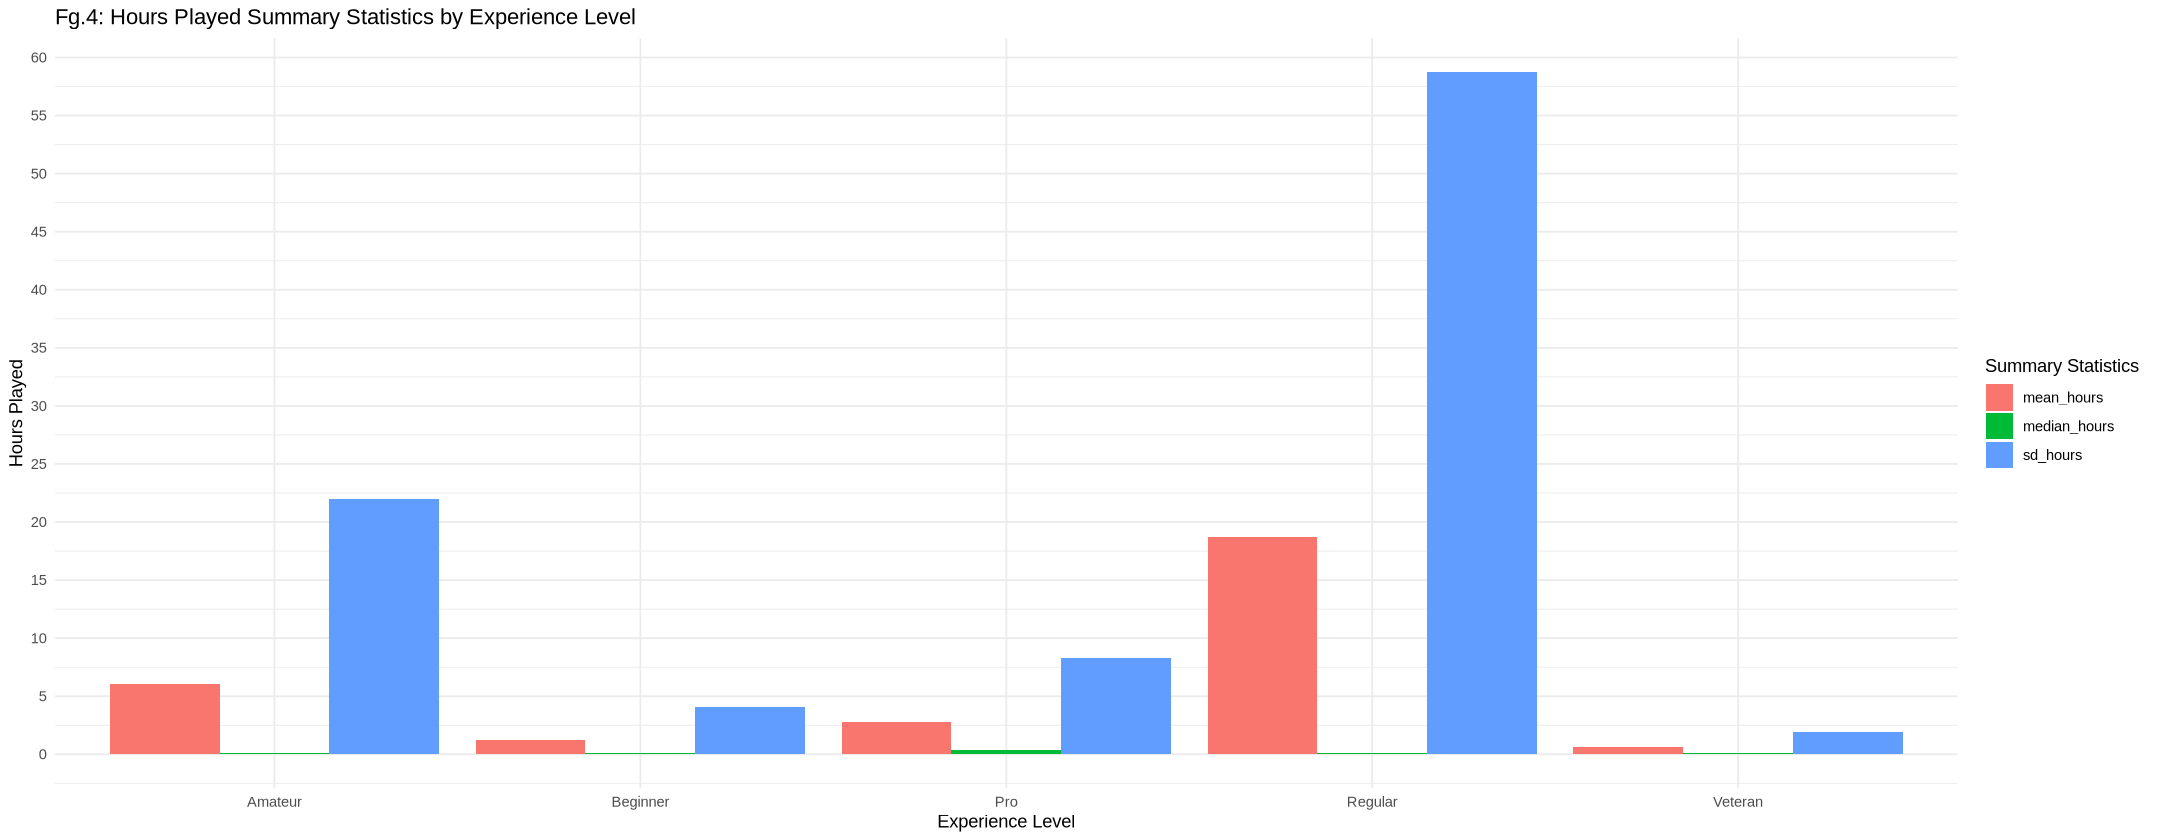

In [9]:
experience_vs_hours <- cleaned_players |>
    group_by(experience) |>
    summarize(mean_hours = mean(played_hours), 
              median_hours = median(played_hours),
              sd_hours = sd(played_hours)) |>
    pivot_longer(cols = c(mean_hours, median_hours, sd_hours),
                 names_to = "summary_type",
                 values_to = "hours") |>
    ggplot(aes(x = experience, y = hours, fill = summary_type)) +
    geom_col(position = "dodge") + 
    labs(title = "Fg.4: Hours Played Summary Statistics by Experience Level",
         x = "Experience Level",
         y = "Hours Played",
         fill = "Summary Statistics") +
    scale_y_continuous(breaks = seq(0, 60, by = 5))+
    theme_minimal()
experience_vs_hours

Following the previous exploration, we computed summary statistics of `age` grouped by each level of `experience`. This allows us to investigate whether age might be a confounding factor in player behavior and subscription likelihood. As shown in Figure 5, there is a slight trend where self-proclaimed expert or pro players tend to be marginally younger than their counterparts.

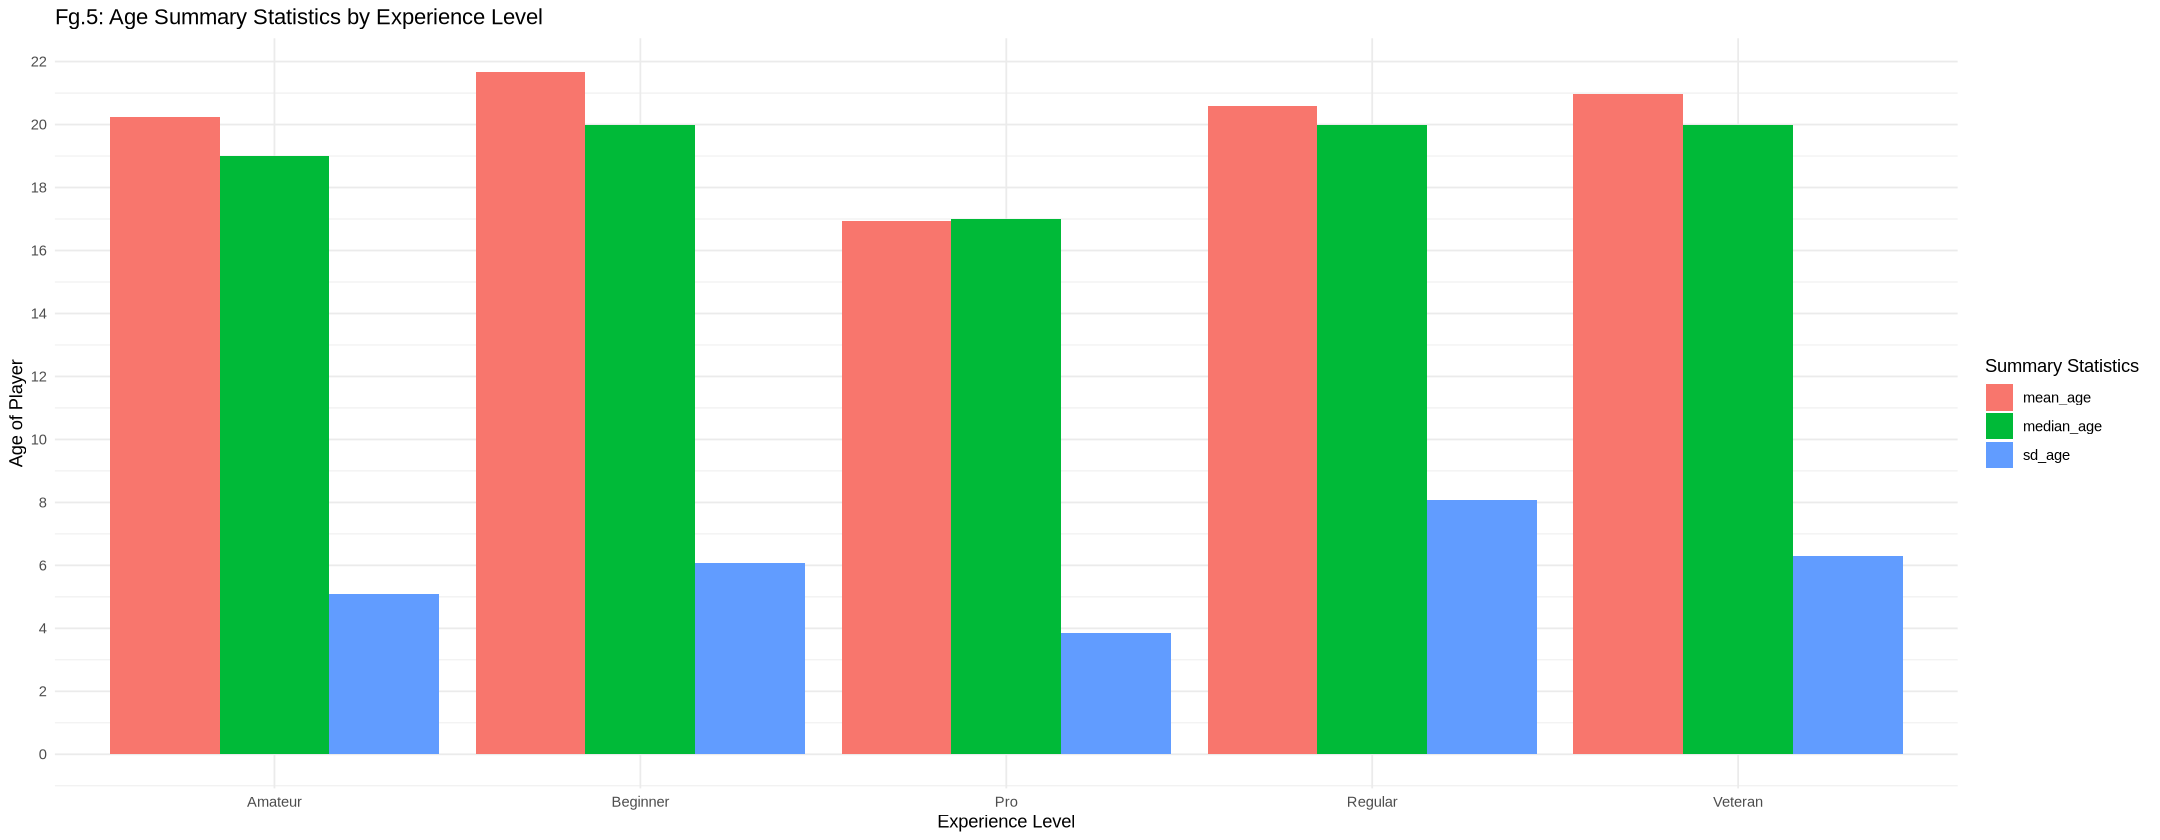

In [10]:
experience_vs_age <- cleaned_players |>
    group_by(experience) |>
    summarize(mean_age = mean(age),
              median_age = median(age),
              sd_age = sd(age)) |>
    pivot_longer(cols = c(mean_age, median_age, sd_age),
                 names_to = "summary_type",
                 values_to = "age") |>
    ggplot(aes(x = experience, y = age, fill = summary_type)) +
    geom_col(position = "dodge") + 
    labs(title = "Fg.5: Age Summary Statistics by Experience Level",
         x = "Experience Level",
         y = "Age of Player",
         fill = "Summary Statistics") +
    scale_y_continuous(breaks = seq(0, 22, by = 2))+
    theme_minimal()
experience_vs_age

To examine whether gameplay activity differs by gender identity, we calculated the statistics of `played_hours` for each gender group. These descriptive statistics help us understand whether gender plays a role in how much players engage with the game. As illustrated with Figure 6, female and non-binary participants show slightly higher average playtime, although variability exists across all groups.

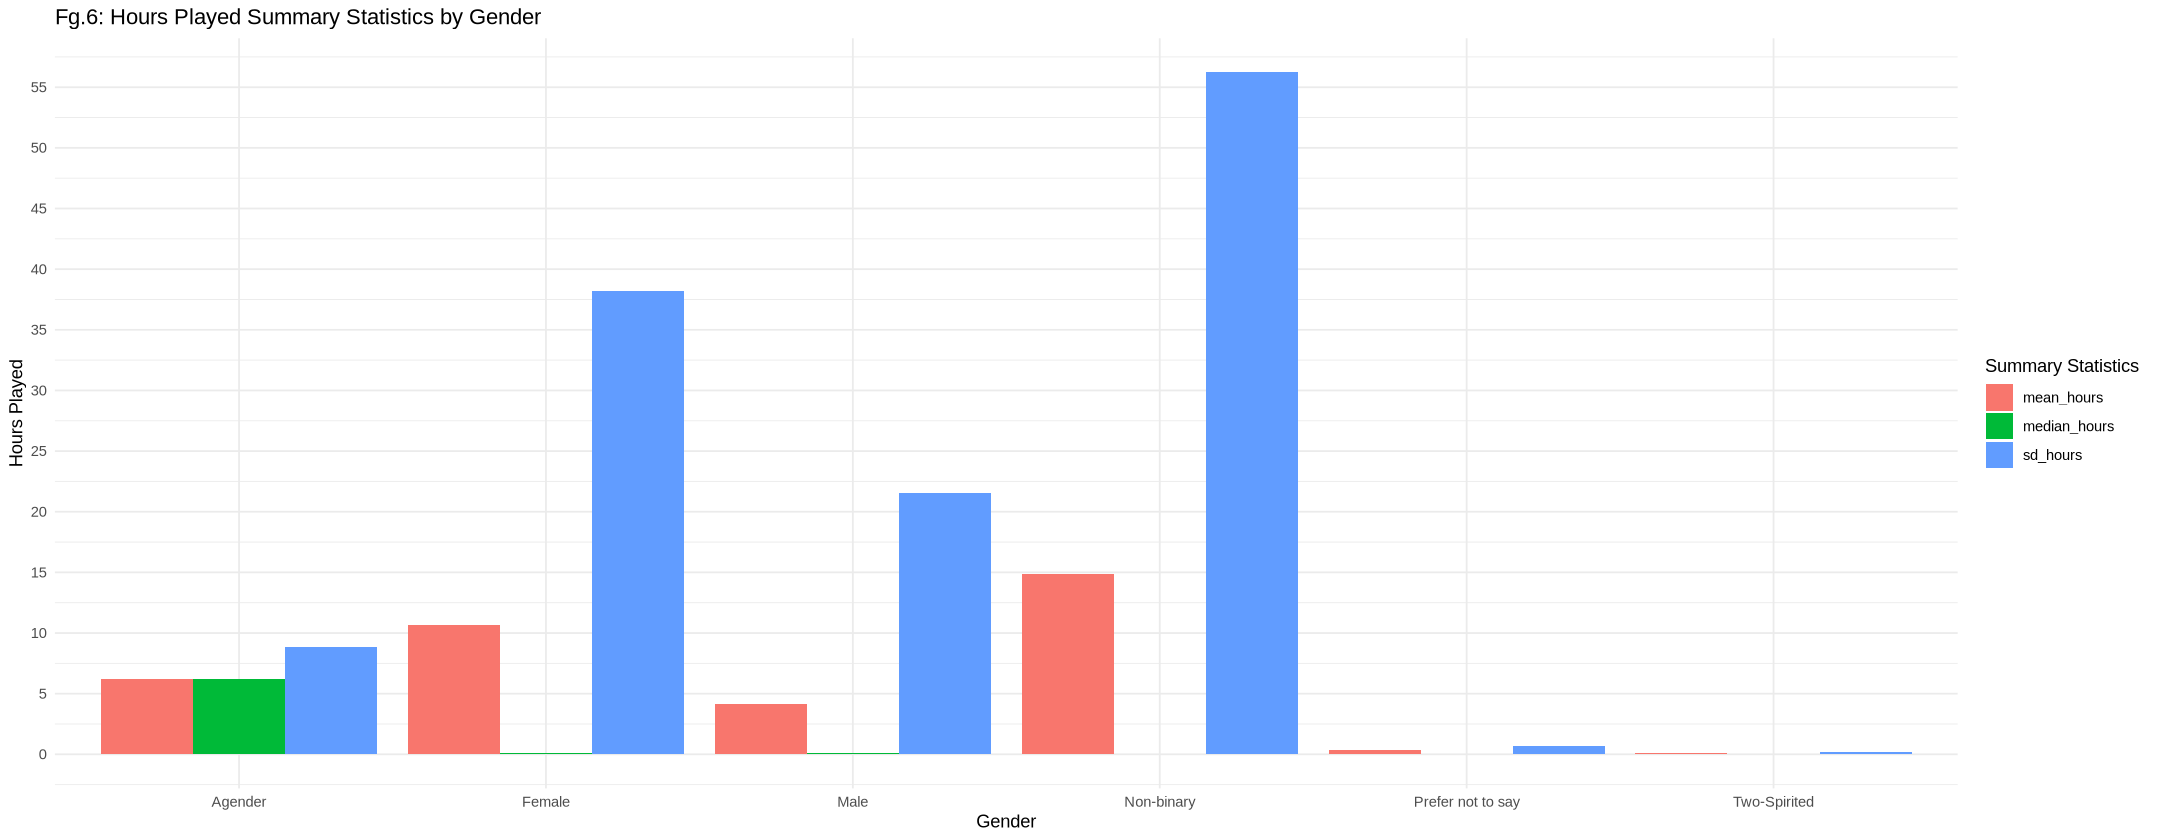

In [11]:
gender_vs_hours <- cleaned_players |>
    group_by(gender) |>
    summarize(mean_hours = mean(played_hours),
              median_hours = median(played_hours),
              sd_hours = sd(played_hours)) |>
    pivot_longer(cols = c(mean_hours, median_hours, sd_hours),
                 names_to = "summary_type",
                 values_to = "hours") |>
    ggplot(aes(x = gender, y = hours, fill = summary_type)) +
    geom_col(position = "dodge") + 
    labs(title = "Fg.6: Hours Played Summary Statistics by Gender",
         x = "Gender",
         y = "Hours Played",
         fill = "Summary Statistics") +
    scale_y_continuous(breaks = seq(0, 60, by = 5))+
    theme_minimal()
gender_vs_hours

Continuing with demographic comparisons, we now explore whether player age also differs across gender groups. By summarizing the statistics of `age` for each gender identity, we aim to uncover potential age-related patterns that could influence player behavior or subscription tendencies. As shown in Figure 7, average ages of the previous established female and non-binary participants tends to 19 years old to 22 years old. Depending on how age and hours played relate with subscription, gender and experience level would tell us which participants groups to recruit for the ongoing study.

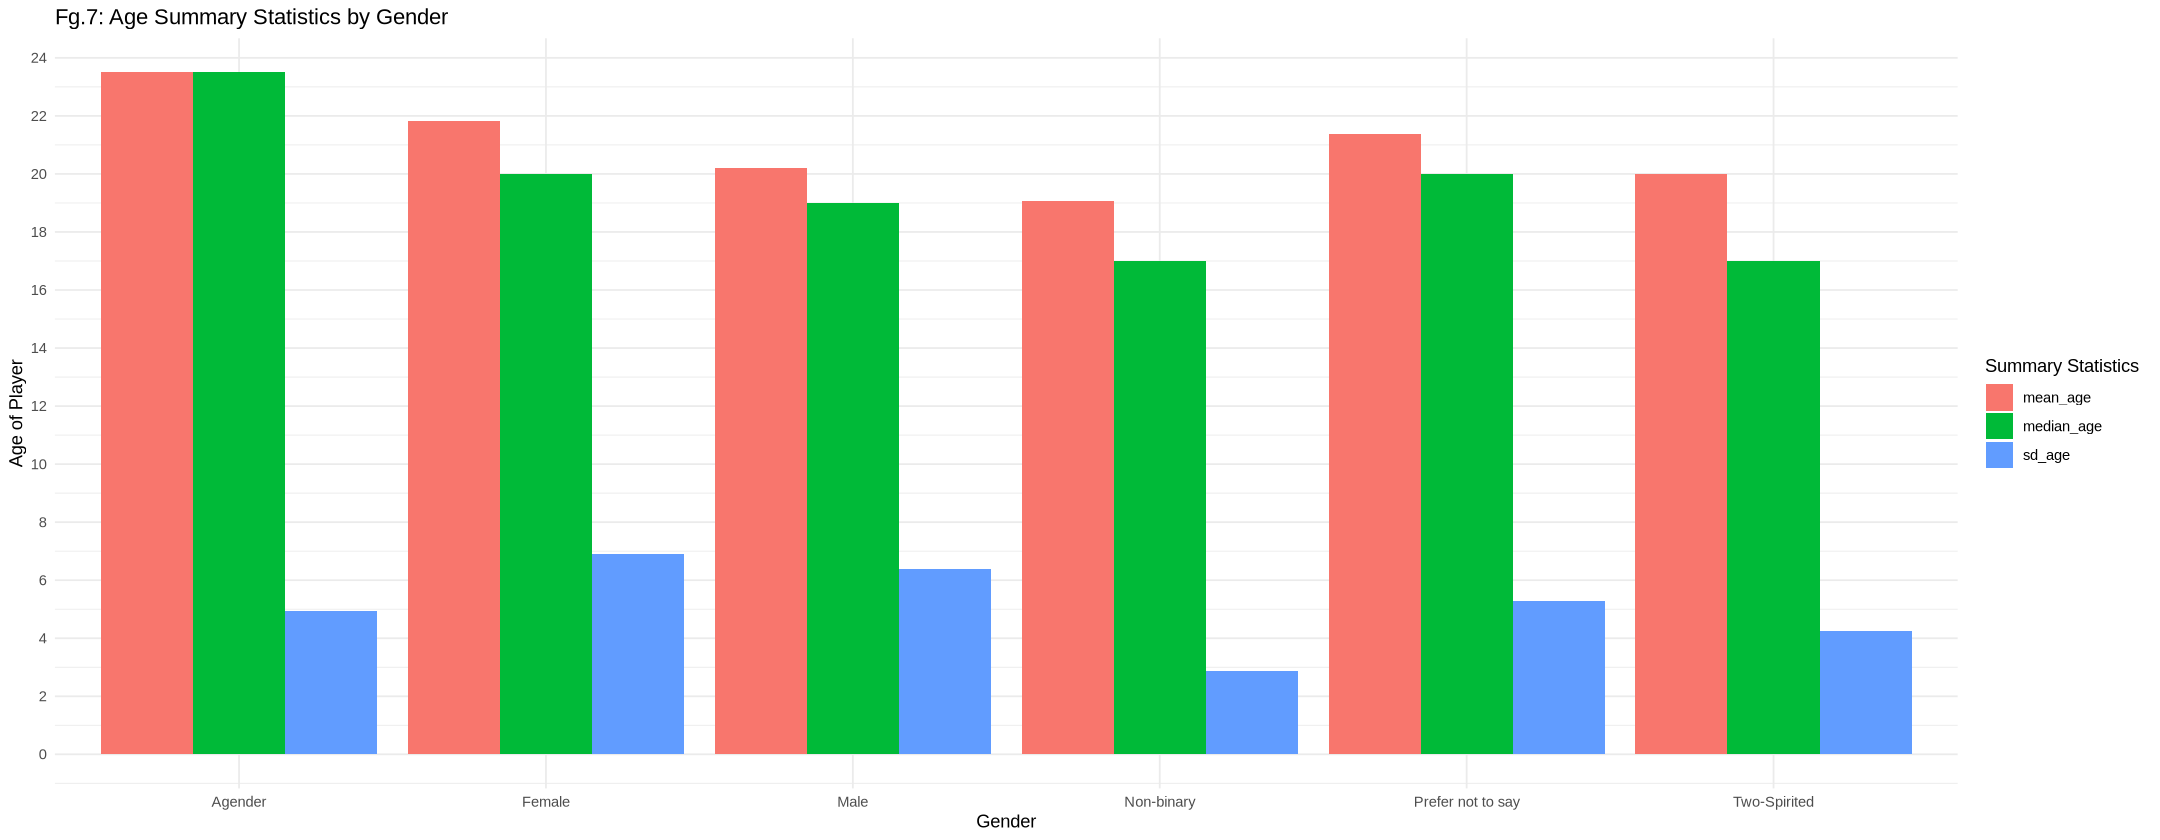

In [12]:
gender_vs_age <- cleaned_players |>
    group_by(gender) |>
    summarize(mean_age = mean(age),
              median_age = median(age),
              sd_age = sd(age)) |>
    pivot_longer(cols = c(mean_age, median_age, sd_age),
                 names_to = "summary_type",
                 values_to = "age") |>
    ggplot(aes(x = gender, y = age, fill = summary_type)) +
    geom_col(position = "dodge") + 
    labs(title = "Fg.7: Age Summary Statistics by Gender",
         x = "Gender",
         y = "Age of Player",
         fill = "Summary Statistics") +
    scale_y_continuous(breaks = seq(0,24, by = 2))+
    theme_minimal()
gender_vs_age

Building on our univariate and grouped comparisons, we now turn to a joint visualization of the two continuous predictors: `played_hours` and `age`. Figure 8 displays a scatterplot of these two variables, with color indicating whether a player subscribed to the game-related newsletter. This unstandardized view allows us to assess the raw relationship between age and playtime, and whether patterns differ across subscription status. \
From the figure, we observe that most players cluster in the lower-left region—indicating lower age and fewer hours played—while a few high-playtime outliers stretch the `x` axis. While clear class separation is not visible, the visualization suggests that both age and playtime may carry predictive information, particularly when scaled and transformed for modeling.

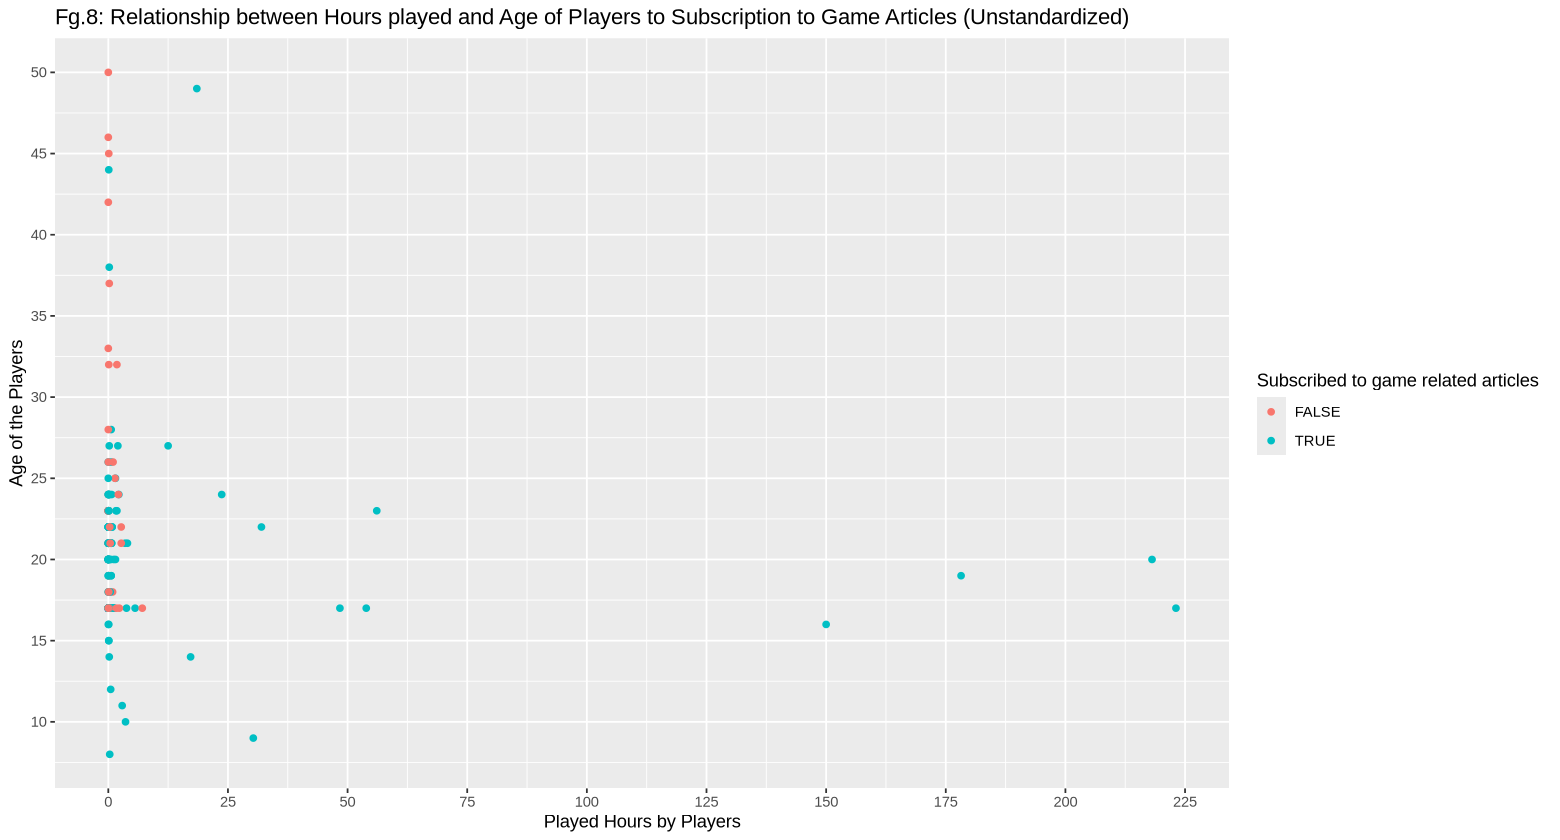

In [13]:
options(repr.plot.width = 13, repr.plot.height = 7)
cleaned_players_plot <- cleaned_players |>
    ggplot(aes(x = played_hours, y = age)) +
    geom_point(aes(color = subscribe)) +
    xlab("Played Hours by Players") +
    ylab("Age of the Players") +
    labs(color = "Subscribed to game related articles") +
    ggtitle("Fg.8: Relationship between Hours played and Age of Players to Subscription to Game Articles (Unstandardized)") +
    scale_y_continuous(breaks = seq(5, 50, by = 5)) +
    scale_x_continuous(breaks = seq(0, 250, by = 25))
cleaned_players_plot

Given the skewness and outlier-heavy distribution of `played_hours` observed in Figure 8, we apply a log transformation to compress extreme values and reduce the influence of outliers. Specifically, we use the `log1p()` transformation to ensure numerical stability for low and zero values. The column is renamed `log_hours` for clarity.
Next, we build a preprocessing recipe using `tidymodels::recipe()` to standardize both predictors (`log_hours` and `age`) by centering and scaling. Standardization ensures that both features contribute equally to distance-based methods like k-Nearest Neighbors (kNN), which are sensitive to differences in scale.

In [14]:
cleaned_players_loged <- cleaned_players |>
    mutate(log_played_hours = log1p(played_hours)) |>
    select(-played_hours) |>
    rename(log_hours = log_played_hours)

cleaned_players_recipe <- recipe(subscribe ~ log_hours + age, data = cleaned_players_loged) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

cleaned_players_scaled <- cleaned_players_recipe |>
    prep() |>
    bake(cleaned_players_loged)

head(cleaned_players_scaled,6)

log_hours,age,subscribe
<dbl>,<dbl>,<fct>
2.80888815,-1.86578776,TRUE
1.01440631,-0.57017138,TRUE
-0.48684676,-0.57017138,FALSE
0.02099412,0.07763681,TRUE
-0.39562959,0.07763681,TRUE
-0.48684676,-0.57017138,TRUE


To verify our preprocessing steps, we summarize the standardized predictors using `stargazer`. As expected, both `log_hours` and `age` now have a mean of approximately 0 and a standard deviation of 1. This ensures that the k-Nearest Neighbors model treats both features equally during distance calculations.

In [15]:
stargazer(
    as.data.frame(cleaned_players_scaled[c("log_hours", "age")]),
    type = "text",
    title = "Summary Statistics",
    digits = 6,
    summary.stat = c("mean", "median", "sd", "min", "max", "n"))


Summary Statistics
Statistic   Mean     Median   St. Dev.    Min      Max     N 
-------------------------------------------------------------
log_hours -0.000000 -0.395630 1.000000 -0.486847 4.692828 194
age       0.000000  -0.246267 1.000000 -2.027740 4.774246 194
-------------------------------------------------------------


After confirming the success of our scaling and transformation steps, we visualize the standardized predictors to assess their structure before modeling. Figure 9 shows a scatterplot of `log_hours` and `age`, both standardized, colored by the subscription status.
This view offers several benefits. First, it makes outliers more interpretable, especially in terms of their standardized distance from the center. Second, by placing both variables on the same scale, we can more intuitively observe potential separability between subscribed and non-subscribed players.
Although clusters remain somewhat mixed, there is a visible skew in the distribution of subscription status — especially among players with higher log-hours and younger standardized ages. This justifies proceeding with a distance-based classifier like kNN, which is sensitive to localized patterns in scaled feature space.

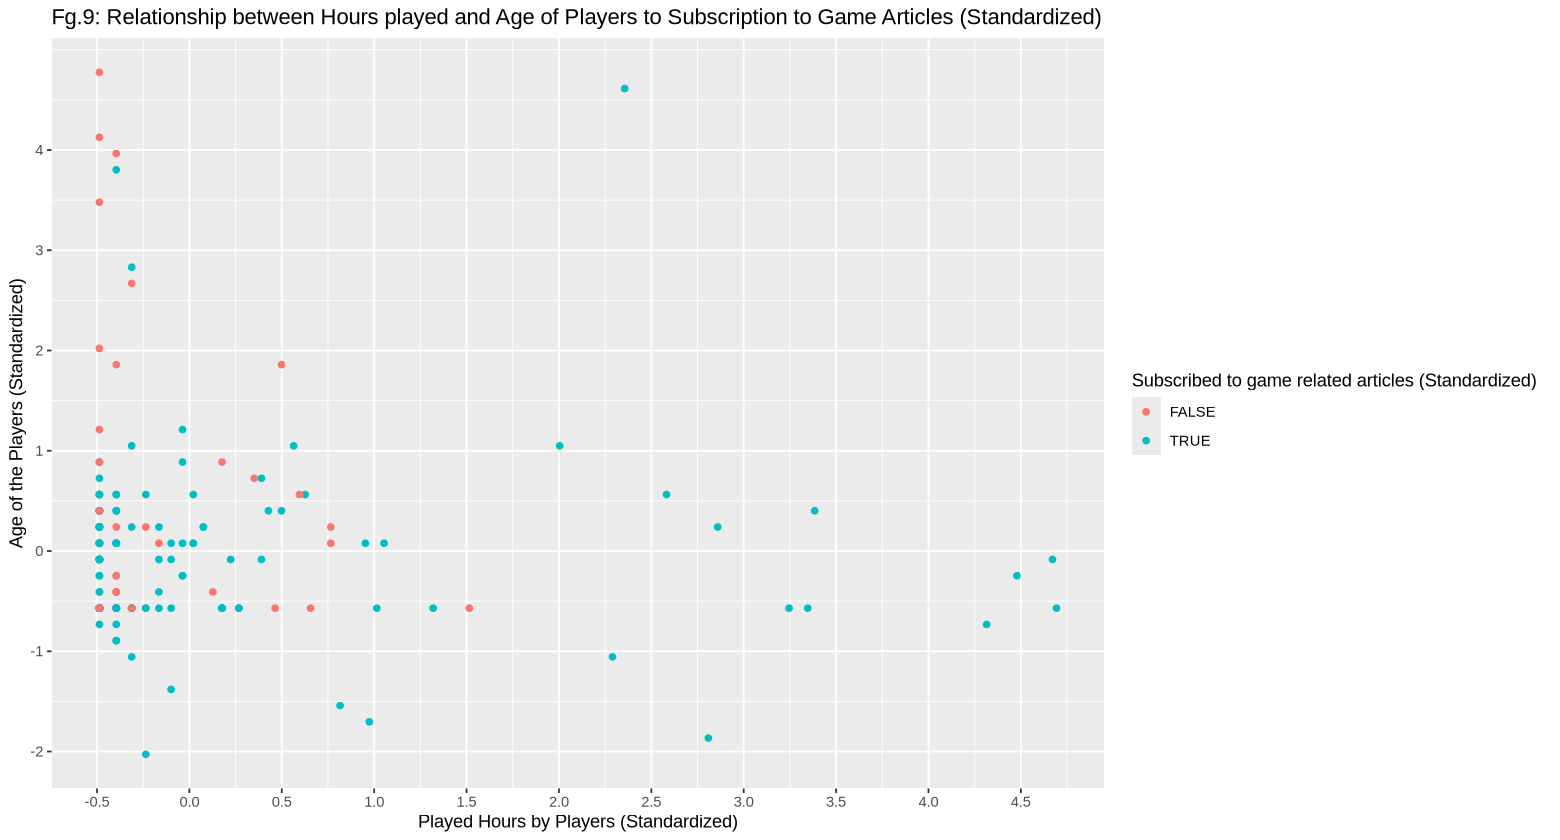

In [16]:
options(repr.plot.width = 13, repr.plot.height = 7)
cleaned_players_plot_standardized <- cleaned_players_scaled |>
    ggplot(aes(x = log_hours, y = age)) +
    geom_point(aes(color = subscribe)) +
    xlab("Played Hours by Players (Standardized)") +
    ylab("Age of the Players (Standardized)") +
    labs(color = "Subscribed to game related articles (Standardized)") +
    ggtitle("Fg.9: Relationship between Hours played and Age of Players to Subscription to Game Articles (Standardized)") +
    scale_y_continuous(breaks = seq(-2, max(cleaned_players_scaled$age), by = 1)) +
    scale_x_continuous(breaks = seq(-0.5, max(cleaned_players_scaled$log_hours), by = 0.5))
cleaned_players_plot_standardized

With the predictors transformed and standardized, we proceed to model fitting. Given our binary response variable (`subscribe`) and the goal of capturing local decision boundaries in the feature space, the k-Nearest Neighbors (kNN) algorithm is a fitting choice.
We use 7 neighbors with a rectangular weight function, meaning each neighbor contributes equally to the vote for class prediction. The model is specified using the `tidymodels` framework and fitted directly on the preprocessed data:

In [17]:
knn_spec<- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
       set_engine("kknn") |>
       set_mode("classification")
knn_fit <- knn_spec |> 
        fit(subscribe ~ log_hours + age, data = cleaned_players_scaled)

To assess how well the model generalizes to new data, we divide the dataset into training and testing subsets. Using the `initial_split()` function, we allocate 75% of the data for training and reserve the remaining 25% for testing, a stardard for splitting models. Importantly, we stratify by the response variable (`subscribe`) to ensure both subsets maintain the same proportion of subscribers and non-subscribers. This stratification helps prevent evaluation bias, especially given the imbalance in subscription rates observed earlier.

In [18]:
players_split <- initial_split(cleaned_players_scaled, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)
head(players_train)
head(players_test)

log_hours,age,subscribe
<dbl>,<dbl>,<fct>
-0.4868468,-0.57017138,FALSE
-0.4868468,0.07763681,FALSE
-0.4868468,0.23958885,FALSE
-0.3956296,-0.57017138,FALSE
-0.4868468,0.56349295,FALSE
-0.4868468,0.40154090,FALSE


log_hours,age,subscribe
<dbl>,<dbl>,<fct>
2.80888815,-1.86578776,TRUE
0.02099412,0.07763681,TRUE
-0.39562959,-0.57017138,TRUE
0.39009466,0.72544499,TRUE
-0.23574950,-2.02773980,TRUE
-0.48684676,0.40154090,FALSE


We now prepare a modeling workflow, which bundles the recipe (preprocessing steps) and model specification into a single object. This approach streamlines both fitting and resampling procedures.
We rebuild our preprocessing recipe using only the training set to avoid data leakage. The recipe includes centering and scaling the predictors (`log_hours` and `age`). We then add our previously defined kNN model (with 7 neighbors) to the workflow and fit it to the training data.

In [19]:
players_recipe <- recipe(subscribe ~ log_hours + age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_train)

With the model trained on the preprocessed training data, we generate predictions for the unseen testing set. The `predict()` function produces class predictions, which we then combine with the original test data using `bind_cols()` for comparison and evaluation.

In [20]:
players_test_predictions <- predict(players_fit, players_test) |>
    bind_cols(players_test)
head(players_test_predictions)

.pred_class,log_hours,age,subscribe
<fct>,<dbl>,<dbl>,<fct>
TRUE,2.80888815,-1.86578776,TRUE
TRUE,0.02099412,0.07763681,TRUE
TRUE,-0.39562959,-0.57017138,TRUE
TRUE,0.39009466,0.72544499,TRUE
TRUE,-0.23574950,-2.02773980,TRUE
FALSE,-0.48684676,0.40154090,FALSE


The resulting data frame includes the predicted subscription outcomes alongside the true values and corresponding predictors. This enables us to assess model performance in the following step using metrics such as accuracy and the confusion matrix. 
\
We assess the model’s predictive performance using accuracy, which measures the proportion of correct predictions out of all predictions made on the test set. This is a straightforward and widely used metric for classification tasks.
The model achieved an accuracy of approximately 63.3%, meaning it correctly predicted subscription outcomes for roughly two-thirds of the players in the test set.

In [21]:
players_prediction_accuracy <- players_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)
players_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.63265306
kap,binary,0.05769231


This result suggests that while the model captures some relationship between player behavior and subscription, there is still considerable room for improvement, potentially through more features or a more flexible model.
\
We also evaluate precision and recall for subscriber class. Astonishingly, both our precision and recall is ~75%, which means when the model predicts a player will subscribe, it is correct about 3 out of 4 times, in which the model correctly identifies about ~75% of actual subscribers. These scores confirm that the model captures some useful signal despite the modest overall accuracy.

In [22]:
players_mat <- players_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
players_mat

          Truth
Prediction FALSE TRUE
     FALSE     4    9
     TRUE      9   27

To optimize model performance, we use 5-fold cross-validation with stratification on the training set. We define a kNN model with `neighbors` set as a tunable hyperparameter (`tune()`):

In [23]:
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

This setup will help us determine the best value of `k` (number of neighbors) for classifying newsletter subscriptions.

In [24]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

We define a grid of `k` values from 1 to 10 and use the `tune_grid()` function to evaluate model performance via 5-fold cross-validation. Accuracy is collected for each value of `k`:

In [25]:
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |>
       add_recipe(players_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = players_vfold, grid = k_vals) |>
       collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4622989,5,0.02140648,Preprocessor1_Model01
1,roc_auc,binary,0.4851732,5,0.02227545,Preprocessor1_Model01
2,accuracy,binary,0.4622989,5,0.02140648,Preprocessor1_Model02
2,roc_auc,binary,0.4854746,5,0.03041851,Preprocessor1_Model02
3,accuracy,binary,0.5037110,5,0.02661809,Preprocessor1_Model03
3,roc_auc,binary,0.4979360,5,0.02756947,Preprocessor1_Model03
4,accuracy,binary,0.5106076,5,0.02833269,Preprocessor1_Model04
4,roc_auc,binary,0.4635823,5,0.03448594,Preprocessor1_Model04
5,accuracy,binary,0.5379310,5,0.04409211,Preprocessor1_Model05


This allows us to identify the number of neighbors that yields the best predictive performance.\
Figure 10 below shows the accuracy estimates from cross-validation across different values of `k` (number of neighbors):

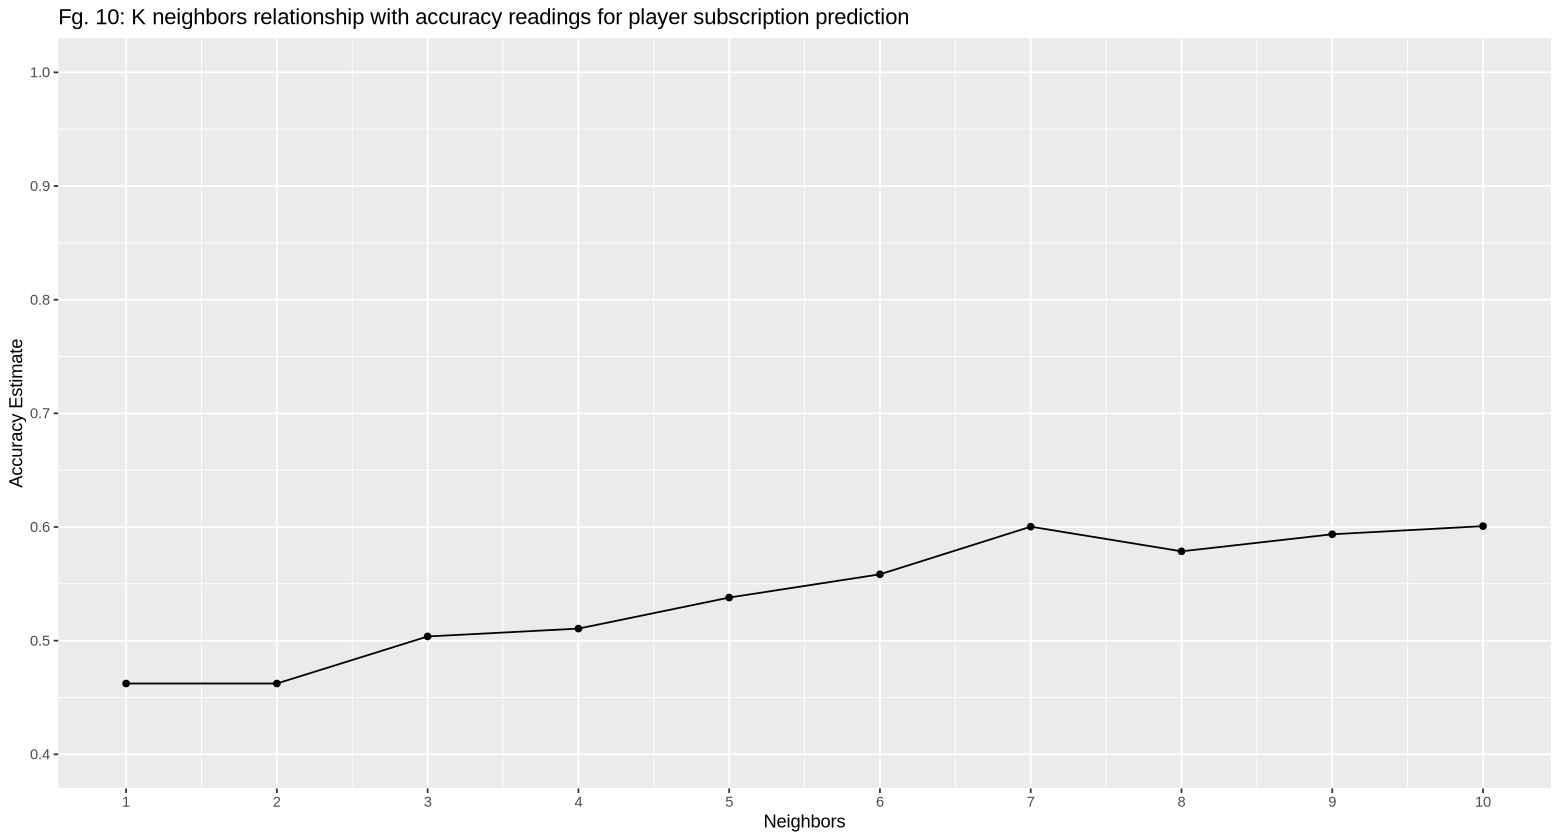

In [26]:
accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(title = "Fg. 10: K neighbors relationship with accuracy readings for player subscription prediction", x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  
       scale_y_continuous(limits = c(0.4, 1.0), breaks = seq(0.4, 1, by = 0.1)) 

accuracy_versus_k

We observe that accuracy peaks around `k = 7 or 10`, which supports the choice made in the final model.

### Result summary
We used a k-Nearest Neighbors (kNN) classification model to predict whether a Minecraft player would subscribe to a game-related newsletter based on their standardized age and logged playtime. kNN was chosen due to its intuitive, non-parametric nature and its suitability for capturing localized relationships without assuming linearity, ideal given the observed distribution and scale of the features. \
No strong distributional assumptions are required for kNN; however, it is sensitive to the scale of input variables and to class imbalance. To address this, we applied log transformation to the `played_hours` variable and standardized both features using centering and scaling. Additionally, the data was stratified by the `subscribe` variable and split into training (75%) and testing (25%) sets to ensure balanced representation during evaluation. Cross-validation with 5 folds on the training data further supported model tuning and helped guard against overfitting. \
We tuned the number of neighbors from 1 to 10 and found that `k = 7` or `k = 10` yielded the best accuracy based on cross-validation (Figure 10). This final model achieved an accuracy of approximately 63.3% on the test set. The confusion matrix showed that the model predicted actual subscribers with reasonable success, though performance on non-subscribers was weaker. Precision and recall for the "subscribe = TRUE" class were both around 75%, indicating the model performed better at identifying subscribers than non-subscribers.

## Discussion
The findings suggest that even basic demographic features like age and playtime contain some predictive power for newsletter subscription, although the signal is modest. This aligns with expectations: player engagement (hours played) likely correlates with interest in game-related content, and younger players may show different engagement patterns. Given previously established relations with factor variables such as `experience` and `gender`, these findings hint at possibly recruiting 19-22 years old, that are not self-proclaimed veterans or pros, for higher likelihood that they would subscribe to game-related newsletters.
\
However, the model’s limited overall accuracy and its imbalance in class prediction reveal the need for additional features, such as in-game behavior from session data or frequency of login, to improve predictions.
\
These insights can guide the research team’s recruitment strategy by highlighting which player types (e.g., highly active or younger users) are more likely to engage further.

## Forecast
Future researchers aiming to improve subscription prediction should consider incorporating richer behavioral data, such as clickstream logs, session frequency, or in-game achievements to add to the `sessions.csv` dataset. These variables are likely to capture nuances in player engagement more effectively than basic demographics. Additionally, applying ensemble models (e.g., random forests) may help capture nonlinear interactions between features. Researchers should also evaluate time-based patterns (such as when players are most active), to align recruitment strategies with peak engagement windows.

## References
Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 
